In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv(r"C:\Users\USER\Desktop\fraud detection pipeline\creditcard.csv")

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(['Time', 'Class'], axis=1))
y_true = data['Class']


In [3]:
iso_forest = IsolationForest(contamination=0.0017, random_state=42)
iso_forest.fit(X)
y_pred_iso = np.where(iso_forest.predict(X) == -1, 1, 0)

print(confusion_matrix(y_true, y_pred_iso))
print(classification_report(y_true, y_pred_iso))


[[283969    346]
 [   353    139]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.29      0.28      0.28       492

    accuracy                           1.00    284807
   macro avg       0.64      0.64      0.64    284807
weighted avg       1.00      1.00      1.00    284807



In [4]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
y_pred_lof = np.where(lof.fit_predict(X) == -1, 1, 0)

print(confusion_matrix(y_true, y_pred_lof))
print(classification_report(y_true, y_pred_lof))


C:\Users\USER\anaconda3\envs\DA1\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


[[283830    485]
 [   492      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



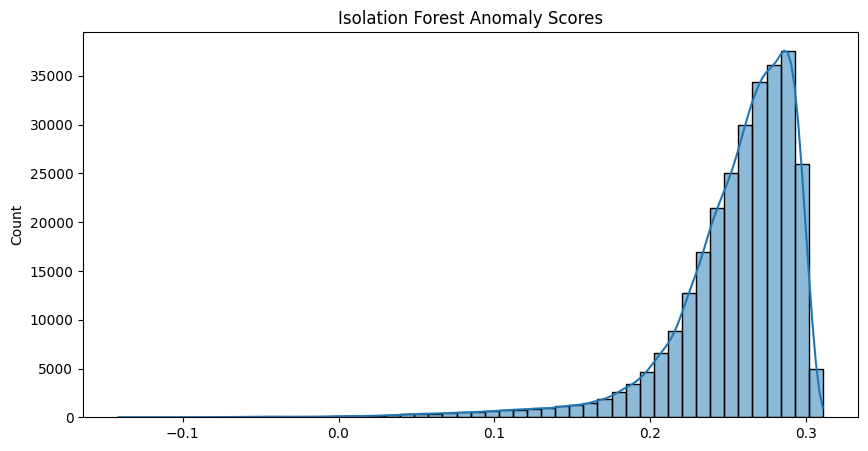

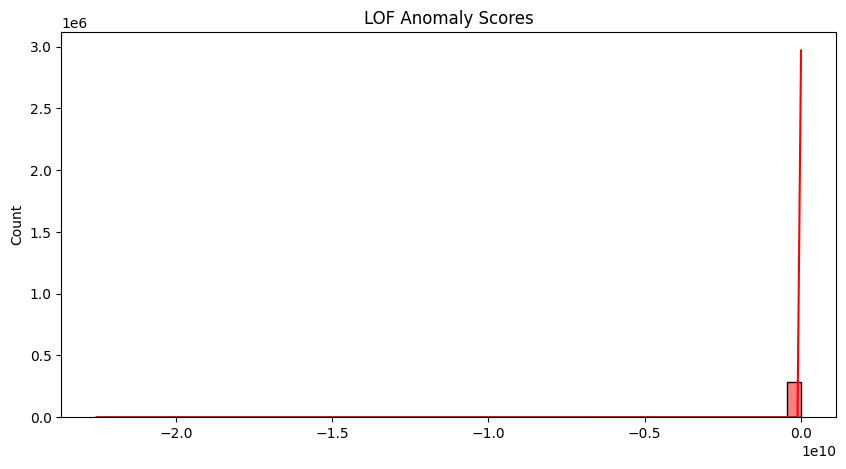

In [5]:
iso_scores = iso_forest.decision_function(X)
plt.figure(figsize=(10,5))
sns.histplot(iso_scores, bins=50, kde=True)
plt.title('Isolation Forest Anomaly Scores')
plt.show()

# LOF scores
lof_scores = lof.negative_outlier_factor_
plt.figure(figsize=(10,5))
sns.histplot(lof_scores, bins=50, kde=True, color='red')
plt.title('LOF Anomaly Scores')
plt.show()


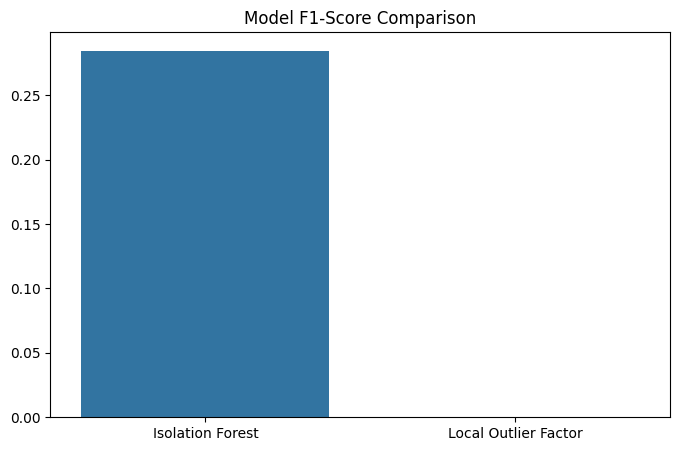

In [6]:
from sklearn.metrics import f1_score

models = ['Isolation Forest', 'Local Outlier Factor']
scores = [f1_score(y_true, y_pred_iso), f1_score(y_true, y_pred_lof)]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=scores)
plt.title('Model F1-Score Comparison')
plt.show()

#Isolation Forest performed better based on F1-Score.

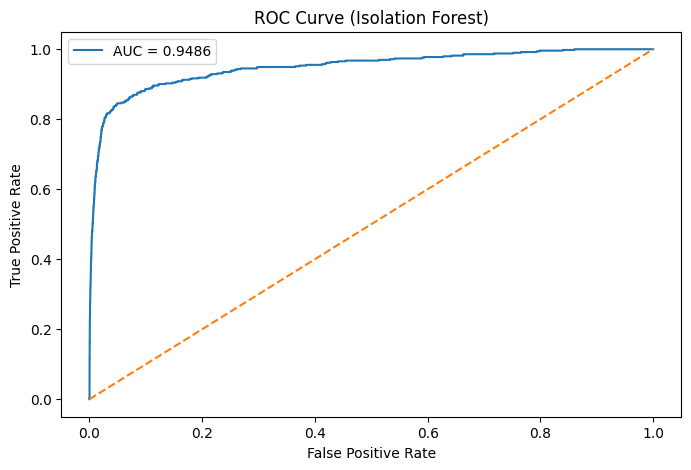

In [7]:

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, iso_scores * -1)
roc_auc = roc_auc_score(y_true, iso_scores * -1)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curve (Isolation Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


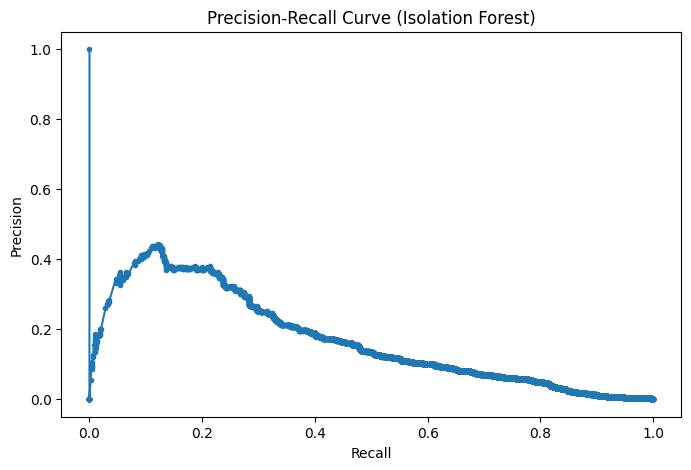

Precision-Recall AUC: 0.1685


In [8]:
#When fraud is like 0.1% of data, accuracy and ROC are misleading! PR curve focuses on frauds directly.
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true, iso_scores * -1)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Area under PR curve
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")


In [ ]:
#Save then use it
import joblib

# Save Isolation Forest
joblib.dump(iso_forest, 'isolation_forest_model.joblib')
# Save scaler after fitting
joblib.dump(scaler, 'scaler.joblib')

import numpy as np
from sklearn.preprocessing import StandardScaler

# Load everything needed
model = joblib.load('isolation_forest_model.joblib')
scaler = joblib.load('scaler.joblib')  # We will save the scaler too
threshold = -0.2  # Example threshold you found earlier

def predict_new_transactions(new_data: pd.DataFrame) -> pd.DataFrame:
    # 1. Scale new data
    new_data_scaled = scaler.transform(new_data)
    
    # 2. Get anomaly scores
    scores = model.decision_function(new_data_scaled)
    
    # 3. Predict based on threshold
    fraud_prediction = np.where(scores < threshold, 1, 0)
    
    # 4. Attach prediction to original data
    result = new_data.copy()
    result['fraud_prediction'] = fraud_prediction
    
    return result
    
# Example: Detect fraud in today's transactions
new_transactions = pd.read_csv('today_transactions.csv')

# Predict
predicted = predict_new_transactions(new_transactions)

# View only frauds
frauds = predicted[predicted['fraud_prediction'] == 1]
print(frauds)
